In [1]:
%load_ext autoreload

In [525]:
%autoreload
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from functools import partial
from tqdm.auto import tqdm
from jax.experimental.optimizers import adam, momentum
import jax.scipy.stats as stats
import jax.experimental.stax as stax
from jx.utils import progress_bar_scan
from jax.config import config
config.update("jax_enable_x64", True)

plt.rcParams['axes.labelsize'] = 25
plt.rcParams['axes.titlesize'] = 25
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.rcParams['figure.figsize'] = (11, 7)

In [324]:
key = jax.random.PRNGKey(0)

In [288]:
def noise(key, dt):
    return jax.random.normal(key) * jnp.sqrt(dt)

# SDE methods

In [512]:
def _sdeint_carry_euler(drift, diffusion, params, aug_fn, y, x):
    dt, i, k = x
    
    dft = drift(y, i * dt, params)
    dfn = diffusion(y, i * dt, params)
    dW = noise(k, dt)
    
    y = y + dft * dt + dfn * dW
    
    if aug_fn:
        aug = aug_fn(y, i * dt, params)
    else:
        aug = None
    
    return y, (y, aug)

def _sdeint_carry_milstein(drift, diffusion, params, aug_fn, y, x):
    dt, i, k = x
    
    dft = drift(y, i * dt, params)
    dfn = diffusion(y, i * dt, params)
    dfn_grad = jax.grad(diffusion)(y, i * dt, params)
    dW = noise(k, dt)
    
    y = y + dft * dt + dfn * dW + 0.5 * dfn * dfn_grad * (dW**2 - dt)
    
    if aug_fn:
        aug = aug_fn(y, i * dt, params)
    else:
        aug = None
    
    return y, (y, aug)

def _sdeint(sde, y0, t, params, key, method='euler'):

    if method == 'euler':
        _sdeint_carry = _sdeint_carry_euler
    elif method == 'milstein':
        _sdeint_carry = _sdeint_carry_milstein
    else:
        raise

    dts = jnp.concatenate((jnp.zeros(1), jnp.diff(t)))
    sdeint_carry = partial(_sdeint_carry, sde['drift'], sde['diffusion'], params, None if 'aug' not in sde.keys() else sde['aug'])
    _, y = jax.lax.scan(sdeint_carry, y0, (dts, jnp.arange(len(t)), jax.random.split(key, len(t))))
    return y

def sdeint(sde, y0, t, params, key, method='milstein'):
    if jnp.ndim(key) > 1:
        assert jnp.ndim(key) == 2
        result = jax.vmap(partial(_sdeint, method=method), in_axes=(None, None, None, None, 0))(sde, y0, t, params, key)
    else:
        result = _sdeint(sde, y0, t, params, key, method=method)
    return result

# Make an Ornstein-Uhlenbeck process

In [501]:
# define the SDE
ou = dict(
    drift = lambda y, t, p: p['theta'] * (p['mu'] - y),
    diffusion = lambda y, t, p: jnp.exp(p['sigma'])
)

# create some initial parameters for the SDE
params = dict(
    theta=1.,
    mu=1.,
    sigma=0.,
)

CPU times: user 11.9 ms, sys: 85 µs, total: 12 ms
Wall time: 10.8 ms
CPU times: user 4.66 ms, sys: 28 µs, total: 4.69 ms
Wall time: 3.52 ms


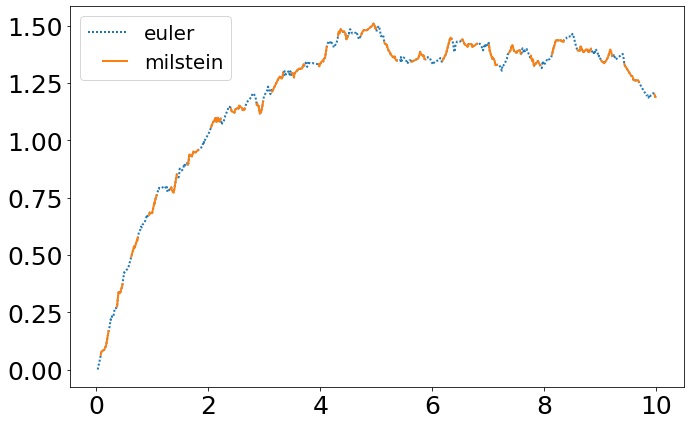

In [502]:
# run sdeint with two different integrators
x = np.sort(jax.random.uniform(key, minval=0., maxval=10., shape=(500,)))
for m, ls in zip(['euler', 'milstein'], [(1, 1, 1), (0, 7, 7)]):
    yplt = sdeint(ou, 0., x, params_true, key, method=m)
    %time plt.plot(x, yplt, label=m, dashes=ls, lw=2)
plt.legend(fontsize=20)

# define MSE loss function and its gradient

In [492]:
run_sde = jax.jit(lambda p, k: sdeint(ou, y[0], x, p, k, method='euler'))
loss = lambda p, k: jnp.sum(jnp.square(run_sde(p, k) - y))
loss_grad = jax.jit(jax.value_and_grad(loss))

# fit to data to get best SDE parameters 

In [493]:
opt_init, opt_update, get_params = momentum(1e-4, 0.9)
opt_state = opt_init(params)

niter = 1000
pbar = progress_bar_scan(niter)
keys = jax.random.split(key, niter)

@jax.jit
def step(opt_state, i_key):
    i, key = i_key
    loss, grad = loss_grad(get_params(opt_state), key)
    opt_state = opt_update(i, grad, opt_state)
    return opt_state, loss

opt_state, losses = jax.lax.scan(
    pbar(step), 
    opt_state, 
    (jnp.arange(niter), keys)
)

params = get_params(opt_state)

  0%|          | 0/1000 [00:00<?, ?it/s]

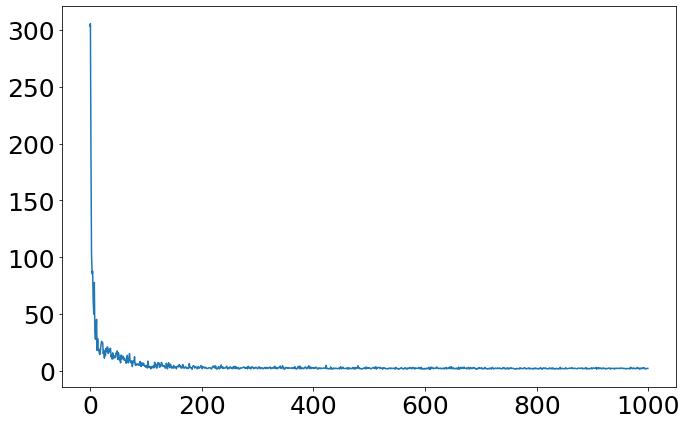

In [494]:
plt.plot(losses)

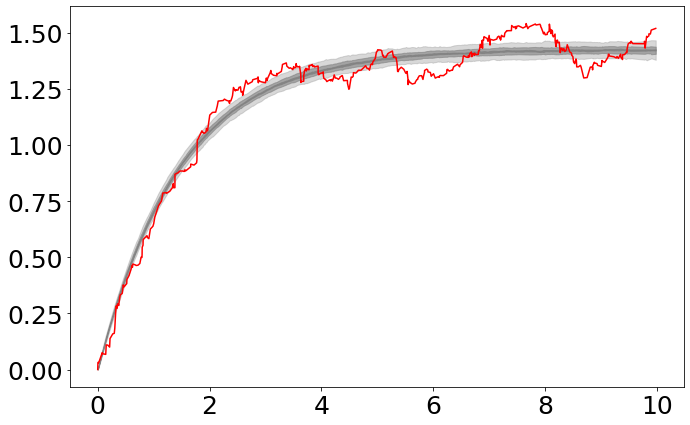

In [495]:
keys = jax.random.split(key, 250)
ys = jax.vmap(run_sde, in_axes=(None, 0))(params, keys)
plt.fill_between(x, *jnp.quantile(ys, jnp.array([0.05, 0.95]), axis=0),alpha=0.3, color='gray')
plt.fill_between(x, *jnp.quantile(ys, jnp.array([0.25, 0.75]), axis=0),alpha=0.6, color='gray')
plt.fill_between(x, *jnp.quantile(ys, jnp.array([0.45, 0.55]), axis=0),alpha=0.8, color='gray')
plt.plot(x, y, c='r')

# Replace drift and diffusion terms with neural networks 

In [297]:
drift_init, drift_apply = stax.serial(
    stax.Dense(64),
    stax.Gelu,
    stax.Dense(1),
)

diffusion_init, diffusion_apply = stax.serial(
    stax.Dense(64),
    stax.Gelu,
    stax.Dense(1),
)

# make SDE

In [371]:
sde_nn = dict(
    drift = jax.jit(lambda y, t, p: drift_apply(p['drift'], y)[0][0]),
    diffusion = jax.jit(lambda y, t, p: diffusion_apply(p['diffusion'], y)[0][0])
)

# define loss

In [372]:
run_sde = jax.jit(lambda p, k: sdeint(sde_nn, y[0], x, p, k, method='euler'))
loss = lambda p, k: jnp.sum(jnp.square(run_sde(p, k) - y))
loss_grad = jax.jit(jax.value_and_grad(loss))

# initialize SDE/network parameters

In [373]:
key, k1, k2 = jax.random.split(key, 3)
_, p_drift_init = drift_init(k1, (1,))
out_shape, p_diffusion_init = diffusion_init(k2, (1,))
nn_params = dict(
    drift = p_drift_init,
    diffusion = p_diffusion_init,
)

# optimize SDE/neural network parameters

In [374]:
opt_init, opt_update, get_params = adam(1e-3)
opt_state = opt_init(nn_params)

niter = 1000
pbar = progress_bar_scan(niter)
keys = jax.random.split(key, niter)

@jax.jit
def step(opt_state, i_key):
    i, key = i_key
    loss, grad = loss_grad(get_params(opt_state), key)
    opt_state = opt_update(i, grad, opt_state)
    return opt_state, loss

losses = []
for i in (pbar := tqdm(range(niter))):
    opt_state, loss = step(opt_state, (i, keys[i]))
    if i % 50 == 0:
        pbar.set_description(f"loss: {loss:.2f}")
    losses.append(loss)

# opt_state, losses = jax.lax.scan(
#     pbar(step), 
#     opt_state, 
#     (jnp.arange(niter), keys)
# )

nn_params = get_params(opt_state)

  0%|          | 0/1000 [00:00<?, ?it/s]

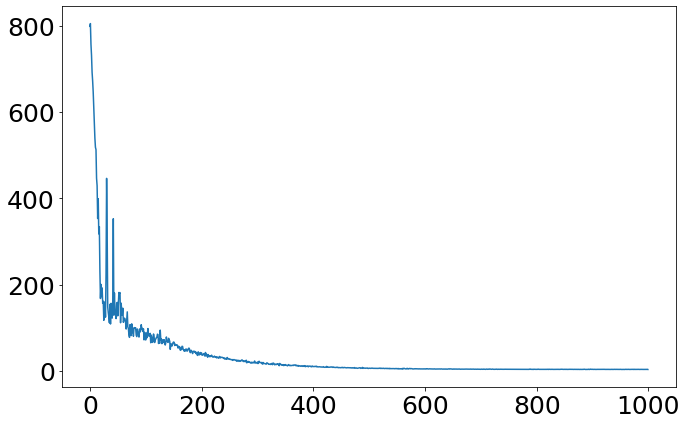

In [375]:
plt.plot(losses)

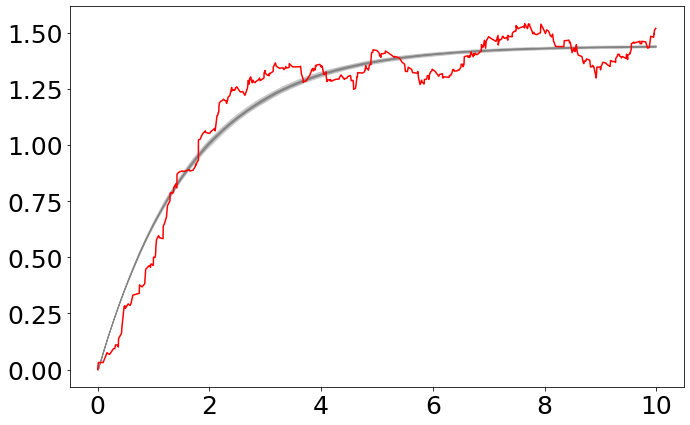

In [376]:
keys = jax.random.split(key, 250)
ys = jax.vmap(run_sde, in_axes=(None, 0))(nn_params, keys)
plt.fill_between(x, *jnp.quantile(ys, jnp.array([0.05, 0.95]), axis=0),alpha=0.3, color='gray')
plt.fill_between(x, *jnp.quantile(ys, jnp.array([0.25, 0.75]), axis=0),alpha=0.6, color='gray')
plt.fill_between(x, *jnp.quantile(ys, jnp.array([0.45, 0.55]), axis=0),alpha=0.8, color='gray')
plt.plot(x, y, c='r')

# diffusion term seems to go to 0, need to regularize

# 
-----------
#

# adapted from torchsde latent_sde.py example

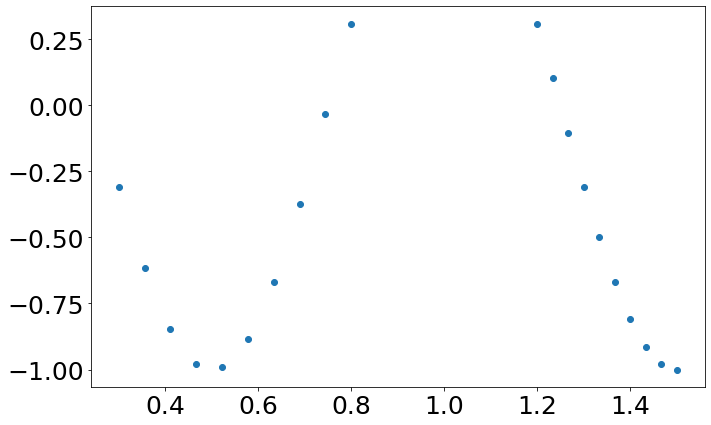

In [641]:
ts = jnp.concatenate((jnp.linspace(0.3, 0.8, 10), jnp.linspace(1.2, 1.5, 10)), axis=0)
ys = jnp.cos(ts * (2. * jnp.pi))
plt.scatter(ts, ys)

In [503]:
def f(y, t, p): 
    inp = jnp.array((jnp.sin(t), jnp.cos(t), y))
    return drift_apply(p['drift'], inp)[0]

In [504]:
def g(y, t, p):
    # return diffusion_apply(p['diffusion'], y)[0][0]
    return jnp.exp(p['sigma'])

In [505]:
def h(y, t, p):
    return p['theta'] * (p['mu'] - y)

In [506]:
def aug_fn(y, t, p):
    f_out, g_out, h_out = f(t, y, p), g(t, y, p), h(t, y, p)
    u = (f_out - h_out) / g_out
    logqp = 0.5 * u**2
    return logqp

In [642]:
drift_init, drift_apply = stax.serial(
    stax.Dense(128),
    stax.Tanh,
    stax.Dense(128),
    stax.Tanh,
    stax.Dense(1),
)

diffusion_init, diffusion_apply = stax.serial(
    stax.Dense(128),
    stax.Tanh,
    stax.Dense(128),
    stax.Tanh,
    stax.Dense(1),
)

In [643]:
key, k1, k2 = jax.random.split(key, 3)
_, p_drift_init = drift_init(k1, (3,))
out_shape, p_diffusion_init = diffusion_init(k2, (1,))

params = dict(
    drift = p_drift_init,
    diffusion = p_diffusion_init,
    sigma = 0.,
    theta = 0.,
    mu = 0.,
)

In [644]:
sde = dict(
    drift = f,
    diffusion = g,
    aug = aug_fn,
)

In [645]:
@jax.jit
def loss_fn(params, keys):
    ys, logqps = sdeint(sde, y[0], x, params, keys)
    logpy = stats.laplace.logpdf(ys, loc=y, scale=0.05).sum(axis=-1).mean()
    kl = logqps.sum(axis=-1).mean()
    loss = -logpy + kl
    return loss

loss_vg = jax.jit(jax.value_and_grad(loss_fn))

In [650]:
opt_init, opt_update, get_params = adam(1e-2)
opt_state = opt_init(params)
# losses = []

In [ ]:
niter = 200
batch_size = 256

keys = jax.random.split(key, niter)

@jax.jit
def step(opt_state, i_key):
    i, key = i_key
    keys = jax.random.split(key, batch_size)
    loss, grad = loss_vg(get_params(opt_state), keys)
    opt_state = opt_update(i, grad, opt_state)
    return opt_state, loss

# for i in (pbar := tqdm(range(niter))):
#     opt_state, loss = step(opt_state, (i, keys[i]))
#     if i % 5 == 0:
#         pbar.set_description(f"loss: {loss:.2f}")
#     losses.append(loss)

pbar = progress_bar_scan(niter)
opt_state, losses = jax.lax.scan(
    pbar(step), 
    opt_state, 
    (jnp.arange(niter), keys)
)

params = get_params(opt_state)

  0%|          | 0/200 [00:00<?, ?it/s]

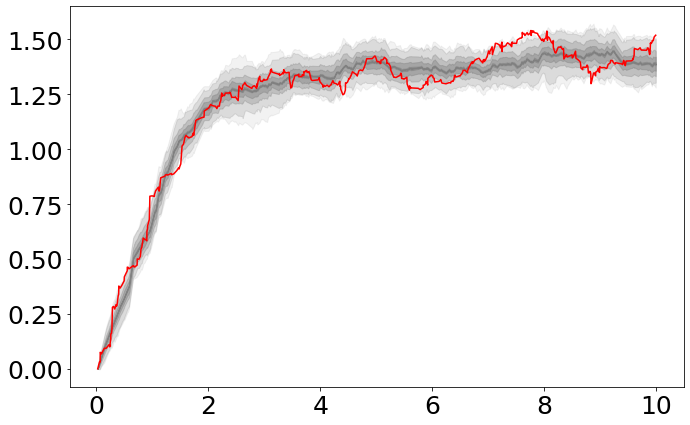

In [635]:
ys, _ = sdeint(sde, y[0], x, params, keys)
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 1.]
percentiles = [0.999, 0.99, 0.9, 0.75, 0.55, 0.5]
for a, p in zip(alphas, percentiles):
    plt.fill_between(x, *jnp.quantile(ys, jnp.array([1. - p, p]), axis=0), alpha=a, color='gray')
plt.plot(x, y, c='r')